In [1]:
%load_ext line_profiler

In [2]:
from IPython.core.display import display, HTML
#display(HTML('<style>.container {width:100% !important;} <\style>'))

In [3]:
from trivariatevectorlinearinterpolation import LinearAimAssister, LinearEigenvectorInterpolator, Dp54Linear

In [4]:
from auxiliarypointstuff import cy_compute_pos_aim, cy_cross_product, \
                                cy_in_plane, cy_orthogonal_component, \
                                cy_parallel_component, cy_normalize, \
                                cy_norm2, cy_min

In [5]:
from ndcurvebsplineinterp import NDCurveBSplineInterpolator # <= Krever Fortran-Python-kobling

In [6]:
from trivariatevectorbsplineinterpolation import SplineAimAssister, SplineEigenvectorInterpolator, Dp54BSpline
# ^ Krever Fortran-Python-kobling

In [136]:
from trivariatescalarinterpolation import TrivariateSpline

In [137]:
lm1s = TrivariateSpline(x,y,z,lm1)

In [165]:
q = lm1_itp.hess(p)

In [166]:
r = np.ones(3)

In [168]:
q, r

(array([[0.86865256, 0.47713917, 0.51403818],
        [0.47713917, 0.87890254, 0.48212033],
        [0.51403818, 0.48212033, 0.82968256]]), array([1., 1., 1.]))

In [167]:
q.dot(r)

array([1.85982991, 1.83816204, 1.82584107])

In [172]:
np.sum(q[...,2])

1.825841068315352

In [138]:
lm1_p_an = lm1[...,0]

<IPython.core.display.Javascript object>


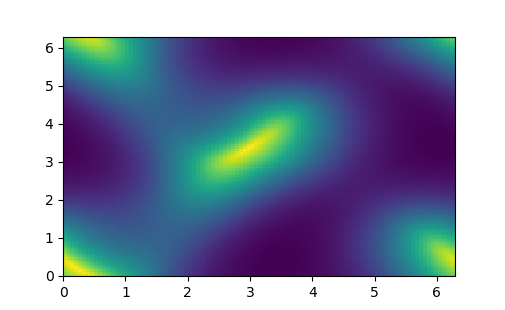

In [140]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(x,y,lm1_p_an.T)

In [141]:
_x = np.linspace(0,2*np.pi,1000)
_y = np.linspace(0,2*np.pi,1001)

In [143]:
lm1_p_itp = np.empty((1000,1001))
for j in range(1001):
    lm1_p_itp[...,j] = [lm1s(np.array([_x[i],_y[j],0])) for i in range(1000)]

<IPython.core.display.Javascript object>


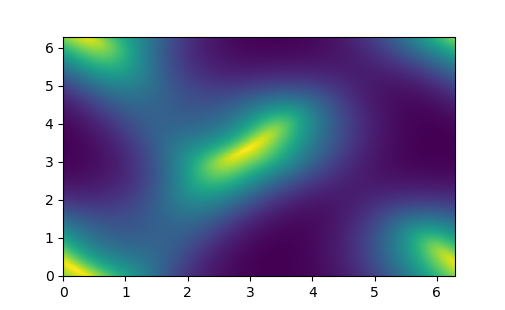

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(_x,_y,lm1_p_itp.T)

In [7]:
import sys
sys.path.insert(0,'../..') # Sett inn det som trengs for at numerical_integrators
                           # blir tilgjengelig i path

In [8]:
from numerical_integrators.singlestep import rk2, rk3, rk4
from numerical_integrators.adaptive_step import rkdp54,rkdp87

In [9]:
import multiprocessing as mp
import numpy as np
from numba import njit
from scipy.interpolate import splprep as scp_splprep,\
                              splev as scp_splev
import time

In [10]:
#np.linalg.norm(v)

In [11]:
import matplotlib as mpl
mpl.use("pgf")

#################################################
##### Fjern kommentarer for bonus-stilpoeng #####
#################################################

# Custom matplotlib config (fonts etc)

## TeX preamble
#pgf_with_pdflatex = {
#    "font.family": "serif",
#    "text.usetex": True,
#    "text.latex.unicode": True,
#    "pgf.texsystem": "pdflatex",
#    "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",
#         r"\usepackage[T1]{fontenc}",
#         r"\usepackage[]{libertine}"
#         r"\usepackage[libertine]{newtxmath}"
#         ]
#}
#mpl.rcParams.update(pgf_with_pdflatex)


#mpl.rcParams['font.family'] = 'Libertine'

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

#import matplotlib.font_manager as fm
#prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

from matplotlib import pyplot as plt
#plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [12]:
def f(t,x,A=1,B=1,C=1):
    """
    param: t -- Time
    param: x -- Twelve-component (NumPy) array, containing the flow map and Jacobian at time t. 
                Shape: (12,nx,ny,nz)
    
    return: Twelve-component array, containing the (component-wise) right hand side of the
            coupled equation of variations
            Shape: (12,nx,ny,nz)
    """
    ret     = np.empty(x.shape)
    ret[0]  = A*np.sin(x[2]) + C*np.cos(x[1])                # x-component of velocity field
    ret[1]  = B*np.sin(x[0]) + A*np.cos(x[2])                # y-component of velocity field
    ret[2]  = C*np.sin(x[1]) + B*np.cos(x[0])                # z-component of velocity field
    ret[3]  = -C*np.sin(x[1])*x[6] + A*np.cos(x[2])*x[9]     # The remaining (coupled) entries 
    ret[4]  = -C*np.sin(x[1])*x[7] + A*np.cos(x[2])*x[10]    # constitute the RHS of the 
    ret[5]  = -C*np.sin(x[1])*x[8] + A*np.cos(x[2])*x[11]    # variational ODE for the 
    ret[6]  = B*np.cos(x[0])*x[3] + -A*np.sin(x[2])*x[9]     # flow map Jacobian
    ret[7]  = B*np.cos(x[0])*x[4] + -A*np.sin(x[2])*x[10]
    ret[8]  = B*np.cos(x[0])*x[5] + -A*np.sin(x[2])*x[11]
    ret[9]  = -B*np.sin(x[0])*x[3] + C*np.cos(x[1])*x[6]
    ret[10] = -B*np.sin(x[0])*x[4] + C*np.cos(x[1])*x[7]
    ret[11] = -B*np.sin(x[0])*x[5] + C*np.cos(x[1])*x[8]
    return ret

def compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,func,integ,nproc=4):
    jac = find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc)
    u,s,v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (np.ascontiguousarray(lm1), np.ascontiguousarray(lm2), np.ascontiguousarray(lm3)), \
            (np.ascontiguousarray(xi1), np.ascontiguousarray(xi2), np.ascontiguousarray(xi3))
    
def find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc):
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))    # Initial conditions (to be advected)
    grid[3]  = 1                                             # Initial condition for the flow map Jacobian: 
    grid[7]  = 1                                             #     Identity matrices
    grid[11] = 1
    
    # Divide the advection across the no. of available processor cores
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int) 
    
    # Initialize queues and processes for multiprocessing
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=_advect_slice,
                     args=(t0,grid[:,div[j]:div[j+1]],tf,h,func,integ,qs[j]))
          for j in range(nproc)]
    
    # Initiate subprocesses
    [p.start() for p in ps]
    # Gather results
    for j, q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    # Enforce termination of each process
    [p.join() for p in ps]
    
    # Return only the Jacobian, reshaped for later convenience
    return grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

def _advect_slice(t0,pos,tf,h,func,integ,q):
    if integ == rk4:
        t = t0
        for j in range(np.ceil((tf-t0)/h).astype(int)):
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    elif integ == rkdp87:
        t = np.ones(pos.shape[1:])*t0
        h = np.ones(pos.shape[1:])*h
        while np.any(t<tf):
            h = np.minimum(h,tf-t)
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    else:
        raise RuntimeError('Integrator configuration not loaded!')

In [13]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
flowmap_integrator = rkdp87

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [14]:
# Compute eigenvalues and -vectors of the Cauchy-Green strain tensor:

(lm1,lm2,lm3),(xi1,xi2,xi3) = compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,f,flowmap_integrator)


In [15]:
# Compute Hessian efficiently by making use of NumPy's gradient function
def compute_hessian_lm(lm,dx,dy,dz):
    grad = np.gradient(lm,dx,dy,dz,edge_order=2)
    hessian = np.empty((x.shape[0],y.shape[0],z.shape[0],3,3))
    for k, grad_k in enumerate(grad):
        # Iterate over the number of dimensions
        # Apply gradient operator to each component of the first derivative
        tmp_grad = np.gradient(grad_k,dx,dy,dz,edge_order=2)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[...,k,l] = grad_kl
    return hessian

In [16]:
# Compute AB subdomain
def find_points_in_ab(hess_lm3,lm3,lm2,xi3):
    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
    return np.logical_and(mask_a,mask_b)

In [17]:
# Currently not used - kept for future reference wrt parameters etc
hlm3 = compute_hessian_lm(lm3,x,y,z)
mask_ab = find_points_in_ab(hlm3,lm3,lm2,xi3)

In [157]:
# Make interpolation objects of lambda 1 through to 3
lm1_itp = TrivariateSpline(x,y,z,lm1,kx=4,ky=4,kz=4,extrap=False)
lm2_itp = TrivariateSpline(x,y,z,lm2,kx=4,ky=4,kz=4,extrap=False)
lm3_itp = TrivariateSpline(x,y,z,lm3,kx=4,ky=4,kz=4,extrap=False)

In [18]:
linear_itp = not not True # <= Må være True så lenge Fortran-Python-kobling ikke er på plass

In [19]:
if linear_itp:
    xi1_itp = LinearEigenvectorInterpolator(x,y,z,xi1)
    xi2_itp = LinearEigenvectorInterpolator(x,y,z,xi2)
    xi3_itp = LinearEigenvectorInterpolator(x,y,z,xi3)
    direction_generator = LinearAimAssister(xi3_itp)
    dp54_p = Dp54Linear(atol = 1e-4, rtol = 1e-4)
else:
    xi1_itp = SplineEigenvectorInterpolator(x,y,z,xi1,3,3,3)
    xi2_itp = SplineEigenvectorInterpolator(x,y,z,xi2,3,3,3)
    xi3_itp = SplineEigenvectorInterpolator(x,y,z,xi3,3,3,3)
    direction_generator = SplineAimAssister(xi3_itp)
    dp54_p = Dp54BSpline(atol = 1e-4, rtol= 1e-4)

In [20]:
dp54_p

In [21]:
# Spesiell lineærinterpolasjon gjøres nå på Cython-nivå, beholder koden i denne cellen som ref

#class LinearSpecialInterpolator:
#    """
#    LinearSpecialInterpolator(xi,x,y,z)
#        
#    A collection of methods to perform linear interpolation with direction correction,
#    of three-dimensional strain eigenvectors.
#        
#    param: xi -- NumPy array of shape (len(x),len(y),len(z),3), containing the eigenvectors xi
#                 given at the grid points spanned by x, y and z
#    param: x  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: y  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: z  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    
#    ******************************************************************************************
#    
#    Methods defined here:
#    
#    LinearSpecialInterpolator.__call__(x)
#    
#    Performs the aforementioned special linear interpolation of the eigenvector xi at
#    the point x.
#    
#    param: x -- Three-component NumPy array, containing the coordinates at which a linear
#                special interpolation of xi is sought; (x,y,z).
#        
#    return: Three-component NumPy array, containing the normalized linearly interpolated
#            xi value at the point x.
#    """
#    def __init__(self,xi,x,y,z):
#        self.xi = xi
#        self.nx = xi.shape[0]-1
#        self.ny = xi.shape[1]-1
#        self.nz = xi.shape[2]-1
#        self.dx = x[1]-x[0]
#        self.dy = y[1]-y[0]
#        self.dz = z[1]-z[0]
#        self.x_min = x[0]
#        self.x_max = x[self.nx-1]
#        self.y_min = y[0]
#        self.y_max = y[self.ny-1]
#        self.z_min = z[0]
#        self.z_max = z[self.nz-1]
#        self.version = '0.1' # To keep track of changes as we go along
#    
#    def __call__(self,x):
#        x, ix, ixp1, y, iy, iyp1, z, iz, izp1 = self._compute_indices_and_weights(x[0],x[1],x[2])
#        cubevecs = [self.xi[ix,iy,iz],
#                    self.xi[ixp1,iy,iz],
#                    self.xi[ix,iyp1,iz],
#                    self.xi[ixp1,iyp1,iz],
#                    self.xi[ix,iy,izp1],
#                    self.xi[ixp1,iy,izp1],
#                    self.xi[ix,iyp1,izp1],
#                    self.xi[ixp1,iyp1,izp1]]
#        # Flip vectors 180 degrees if they are rotated more than 90 degrees with regards to
#        # an arbitrary reference point within the interpolation voxel
#        for i in range(8):
#            if cubevecs[0].dot(cubevecs[i]) < 0:
#                cubevecs[i] = -cubevecs[i]
#        
#        # 
#        return LinearSpecialInterpolator._normalized_weighted_sum(cubevecs,x,y,z)
#    
#    def _compute_indices_and_weights(self,x,y,z):
#        """
#        param: x -- x-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: y -- y-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: z -- z-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#                    
#        return: x    -- Normalized relative coordinate within the interpolation voxel
#        return: ix   -- Index indicating the corners of the interpolation voxel
#        return: ixp1 -- Index indicating the corners of the interpolation voxel
#        return: y    -- Normalized relative coordinate within the interpolation voxel
 #       return: iy   -- Index indicating the corners of the interpolation voxel
 #       return: iyp1 -- Index indicating the corners of the interpolation voxel
 #       return: z    -- Normalized relative coordinate within the interpolation voxel
 #       return: iz   -- Index indicating the corners of the interpolation voxel
 #       return: izp1 -- Index indicating the corners of the interpolation voxel
 #       """
 #       x = np.fmod((x-self.x_min)/self.dx,self.nx)
 #       y = np.fmod((y-self.y_min)/self.dy,self.ny)
 #       z = np.fmod((z-self.z_min)/self.dz,self.nz)
 #       
 #       while x < 0:
 #           x += self.nx
 #       while y < 0:
 #           y += self.ny
 ##       while z < 0:
 #           z += self.nz
 #           
 #       ix = np.floor(x).astype(int)
 #       iy = np.floor(y).astype(int)
 #       iz = np.floor(z).astype(int)
 #       
 #       x -= ix
 #       y -= iy
 #       z -= iz
 #       
 #       ixp1 = int((ix+1)%self.nx)
 #       iyp1 = int((iy+1)%self.ny)
 #       izp1 = int((iz+1)%self.nz)
 #       
 #       return x, ix, ixp1, y, iy, iyp1, z, iz, izp1
 #   
 #   @staticmethod
 #   def _normalized_weighted_sum(cubevecs,x,y,z):
 #       """
 #       param: cubevecs -- List of xi vectors defined at the corners of the interpolation voxel
 #       param:        x -- Normalized relative coordinate within the interpolation voxel
 #       param:        y -- Normalized relative coordinate within the interpolation voxel
 #       param:        z -- Normalized relative coordinate within the interpolation voxel
 #       
 #       return:     vec -- Normalized linearly interpolated xi vector 
 #       """
 #       vec = ((cubevecs[0]*(1-x) + cubevecs[1]*x)*(1-y) + (cubevecs[2]*(1-x) + cubevecs[3]*x)*y)*(1-z)  \
 #               +((cubevecs[4]*(1-x) + cubevecs[5]*x)*(1-y) + (cubevecs[6]*(1-x) + cubevecs[7]*x)*y)*z
 #       return vec/np.linalg.norm(vec)

In [22]:
# Sikting gjøres nå på Cython-nivå. Beholder koden i denne cellen som ref.

#class AimAssister:
#    """
#    AimAssister(target,xi1,xi2)
#    
#    A collection of methods to assist with the process of computing the best
#    targetting aproximation of a point based on linear combinations of
#    the local eigenvectors xi1 and xi2.
#        
#    param: target -- NumPy array containing the coordinates of the point we're aiming for
#    param:    xi1 -- A LinearSpecialInterpolator instance, calibrated for xi1
#    param:    xi2 -- A LinearSpecialInterpolator instance, calibrated for xi2
#    
#    ****************************************************************************************
#    
#    Methods defined here:
#    
#    AimAssister.__call__(t,x)
#    
#    param: t -- Dummy variable, required when using an adaptive stepsize integrator to track
#                arclength (i.e., pseudotime)
#    param: x -- The current point, at which one wants to obtain the component of the
#                vector separating *this* and the target, within the plane spanned
#                by the local xi1 and xi2 vectors
#                    
#    return: Normalized 'best-estimate' vector component in the plane spanned by xi1 and xi2
#    """
#    def __init__(self, target, xi1, xi2):
#        self.target = target
#        self.xi1 = xi1
#        self.xi2 = xi2
#        self.a1 = False
#        self.a2 = False
#        self.fixed = False
#    
#    def __call__(self, t, x):
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        
#        if not self.fixed:
#            
#
#            r = self.target-x
#            r /= np.linalg.norm(r)
#
#            a1 = np.dot(xi1, r)
#            a2 = np.dot(xi2, r)
#        else:
#            a1 = self.a1
#            a2 = self.a2
#        
#        vec = a1*xi1 + a2*xi2
#        #print('a1 =', a1, 'a2 =', a2)
#        return vec/np.linalg.norm(vec)
#    
#    def fix(self,x):
#        r = self.target-x
#        r /= np.linalg.norm(r)
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        self.a1 = np.dot(xi1, r)
#        self.a2 = np.dot(xi2, r)
#        self.fixed = True

In [23]:
# Dummy classes, which replace the LinearSpecialInterpolator instances
# in 'AimAssister' when a spherical shell is considered
class Evec1:
    def __call__(self,x):
        vec = np.array([x[0]*x[2],x[1]*x[2],-x[1]**2-x[0]**2])
        return vec/np.linalg.norm(vec)
class Evec2:
    def __call__(self,x):
        vec=np.array([x[1],-x[0],0])
        return vec/np.linalg.norm(vec)    

In [89]:
##### Manifold class #####

class Manifold:
    """
    Manifold(init_pos,min_u_step,max_u_step,dist,dist_tol,min_ang,max_ang,
                      min_dist_ang,max_dist_ang,min_sep,max_sep)
             
    A wrapper class for a set of the geodesic level sets which
    constitute an invariant manifold.
    
    param:     init_pos -- NumPy array containing the initial position (x,y,z)
                           from which the manifold is constructed
    param:    dom_bound -- Lower and upper boundaries of domain in which the
                           manifold may be developed.
                           Form: [x_low, x_up, y_low, y_up, z_low, z_up]
    param: max_geo_dist -- Maximum geodesic distance. Used to terminate
                           development of manifold
    param:   min_u_step -- Minimum step along the u abscissa (for local
                           evaluation of b-spline interpolations of 
                           any given level set)
    param:   max_u_step -- Minimum step along the u abscissa (for local
                           evaluation of b-spline interpolations of 
                           any given level set)
    param:         dist -- The (initial) radial distance from each
                           point in a given level set, to the 
                           'radially connected' point in the
                           construction of the next level set
    param:     dist_tol -- Numerical tolerance parameter for the
                           above. 0 <= dist_tol <= 1
    param:    plane_tol -- Numerical tolerance parameter for the acceptance of
                           points as members of a plane
    param:      tan_tol -- Tolerance for angular offset between consecutive
                           tangential (half-plane defining) vectors
                           (used in normalized dot product)
    param:      min_ang -- Minimal radial angular deviation between
                           consecutive constructed level sets,
                           under which 'dist' is increased
                           before the _next_ level set is 
                           constructed
    param:      max_ang -- Maximal radial angular deviation between
                           consecutive constructed level sets,
                           over which 'dist' is decreased,
                           the most recent attempt at creating
                           a level set is discarded, and
                           attempted anew with decreased 'dist'
    param: min_dist_ang -- Minimal product of 'dist' and
                           radial angular deviation between
                           consecutive constructed level sets,
                           under which 'dist' is increased
                           before the _next_ level set is
                           constructed
    param: max_dist_ang -- Maximal product of 'dist' and
                           radial angular deviation between
                           consecutive constructed level sets,
                           over which 'dist' is decreased,
                           the most recent attempt at creating
                           a level set is discarded, and
                           attempted anew with decreased 'dist'
    param:      min_sep -- Minimal distance allowed between
                           (neighboring) points in a level set.
    param:      max_sep -- Maximal distance allowed between
                           (neighboring) points in a level set
                          
    ****************************************************************************************
    
    Methods defined here:
    
    Manifold.add_level_sets(num_sets_to_add, dist)
    
    param: num_sets_to_add -- The number of level sets to add
    param: dist            -- The radial distance separating
                              points in consecutive level sets
        
    """
  
  # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_u_step, max_u_step, dist, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep):
        
        self.levelsets    = []
        self.dist         = dist
        self.num_sets     = 0
        self.geo_dist     = 0
        self.input_params = InputManifoldParameters(init_pos, dom_bound, max_geo_dist, min_u_step, max_u_step, 
                 dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep)
        
    def add_level_sets(self, num_sets_to_add):
        n = 0
        if self.num_sets == 0 and num_sets_to_add > 0:
            self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params))
            self.num_sets += 1
            n += 1
        
        while (n < num_sets_to_add and self.geo_dist <= self.input_params.max_geo_dist):
            t_start = time.time()
            try:
                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params,
                                                      self.levelsets[self.num_sets-1]))
            except NeedSmallerDist as e:
                if (self.dist > self.input_params.min_sep):
                    self.dist = self.input_params.min_sep
                    try:
                        self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist,
                                                       self.input_params, self.levelsets[self.num_sets-1]))
                    except NeedSmallerDist as e:
                        print('Could not complete Geodesic level set number', n, '-> terminating script')
                        raise RuntimeError('Failed to locate needed point at minimum step length.')
                else:
                    raise RuntimeError('Failed to locate needed point at minimum step length.')
            except OutsideDomain as e:
                print(e.value)
                break
        
            self.num_sets += 1
            self.geo_dist += self.dist
            self.dist = self.levelsets[-1].next_dist
            n += 1
            print('Geodesic level set', len(self.levelsets), 'completed -> Points:' , 
                  len(self.levelsets[-1].points), ',Time:', time.time() - t_start, 'seconds')
        if (self.geo_dist > self.input_params.max_geo_dist):
            print('Max geodesic distance reached')
    
    def checkABD(self):
        for level in self.levelsets:
            for point in level.points:
                if (point.in_ABD == None):
                    point.is_in_ABD()
        print('Points in ABD identified.')

In [90]:
class InputManifoldParameters:

    # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep):

        self.init_pos     = init_pos
        self.max_geo_dist = max_geo_dist
        self.dom_bound    = dom_bound
        self.min_s_step   = min_s_step
        self.max_s_step   = max_s_step
        self.dist_tol     = dist_tol
        self.plane_tol    = plane_tol
        self.tan_tol      = tan_tol
        self.min_ang      = min_ang
        self.max_ang      = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep      = min_sep
        self.max_sep      = max_sep

In [91]:
##### Geodesic level set class #####

class GeodesicLevelSet:
    
    # Constructor
    def __init__(self, level_num, dist, input_params, prev_set=None):
        
        self.dist         = dist
        
        # Set in sub-functions: self.next_dist
        
        if (level_num == 0):
            new_set = self.generate_first_set(input_params)
        else:       
            set_suggestion = self.generate_set(dist, input_params, prev_set)
            new_set = self.revise_set(set_suggestion, prev_set, input_params)
            
            
        
        #q.append(set_suggestion)
        self.points = new_set
        self.next_dist = self.dist
        #q1.append(self.points)
            
        # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
        # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt

        #self.points.append(self.points[0])
        self.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in self.points]),wraparound=True)
        #self.tck, self.u = scp_splprep([[point.pos[i] for point in self.points] for i in range(3)], s=0)
        # Fjern duplikatpunkt fra punktliste og interpolasjonsparameterliste
        #self.points.pop()
        #self.u = self.u[:-1]
            
    def generate_first_set(self, input_params):
        first_set = []
        # Parameters only used in this function
        init_radius_dist_factor = 1/10
        init_radius = self.dist*init_radius_dist_factor
        init_set_extra_points = 0
        if (np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) < 6):
            init_set_extra_points = 4
        
        # Compute an integer number of points that satisfies both min_dist and max_dist
        n_points = np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) + init_set_extra_points
        print('Number of points in first geodesic level: {}'.format(n_points))
        #ix1 = Evec1() # <= For spherical shell
        #ix1 = LinearSpecialInterpolator(xi1,x,y,z) # <= For ABC flow
        #ix2 = Evec2() # <= For spherical shell
        #ix2 = LinearSpecialInterpolator(xi2,x,y,z) # <= For ABC flow
        for i in range(n_points):
            newcoord = input_params.init_pos + init_radius*(xi1_itp(input_params.init_pos)
                        *np.cos(2*np.pi*i/n_points) + xi2_itp(input_params.init_pos)*np.sin(2*np.pi*i/n_points))
            if (not in_domain(newcoord, input_params.dom_bound)):
                raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
            first_set.append(Point(pos=newcoord, prev_vec=cy_normalize(newcoord - input_params.init_pos),
                                tan_vec=cy_normalize(cy_cross_product(cy_normalize(cy_cross_product(xi1_itp(input_params.init_pos),
                                xi2_itp(input_params.init_pos))), cy_normalize(newcoord - input_params.init_pos)))))
        self.next_dist = self.dist
        
        return first_set
        
    def generate_set(self, dist, input_params, prev_set):
        set_suggestion = []
        if not prev_set:
            raise RuntimeError('Missing previous geodesic level set!')
        for i in range(len(prev_set.points)):
            try:
                set_suggestion.append(Point.find_ordinary_point(i, prev_set, input_params, dist, inbetween=False))
                if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                    raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
            except PointNotFound as e:
                best_point, valid_point = self.find_difficult_point(i, prev_set, input_params, inbetween=False)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.append(best_point)
                else:
                    print(valid_point)
                    raise NeedSmallerDist('Resetting with smaller dist')
        return set_suggestion

    # Check that all restrictions are satisfied + setting next_dist
    def revise_set(self, set_suggestion, prev_set, input_params):
        
        # Curvature tests
        over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                     input_params.max_ang)
        over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points,
                                            self.dist, input_params.min_dist_ang, input_params.max_dist_ang)

        # If curvature is too large
        dist_reduced = False
        while ((over_max_ang or over_max_dist_ang) and self.dist >= 2*input_params.min_sep):
            self.dist = self.dist/2
            set_suggestion = []
            for i in range(len(prev_set.points)):
                try:
                    set_suggestion.append(Point.find_ordinary_point(i, prev_set, input_params, self.dist, 
                                                                 inbetween=False))
                    if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                        raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
                except PointNotFound as e:
                    try:
                        best_point, valid = self.find_difficult_point(i, prev_set, input_params, inbetween=False)
                        if (not in_domain(best_point.pos, input_params.dom_bound)):
                            raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
                        if valid:
                            set_suggestion.append(best_point)
                        else:
                            raise NeedSmallerDist('Point not found upon throwing shit at wall in revise_set')
                    except NeedSmallerDist as e:
                        raise e
            over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                    input_params.max_ang)
            over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points, 
                                                self.dist, input_params.min_dist_ang, input_params.max_dist_ang)
            dist_reduced = True
            self.next_dist = self.dist
        if ((over_max_ang or over_max_dist_ang)):
            print('Smaller step than min_sep required with current requirements. Continuing anyway')
        # If curvature is very small
        if (under_min_ang and under_min_dist_ang and not dist_reduced):
            self.next_dist = min(self.dist*2, input_params.max_sep)
        else:
            self.next_dist = self.dist
        # Check whether neighboring points are close enough to each other
        add_point_after = max_dist_test(set_suggestion, input_params.max_sep)
        
        j = 0
        
        # Insert points wherever points are too far from each other
        for i in add_point_after:
            try:
                set_suggestion.insert(i+j+1, Point.find_ordinary_point(i, prev_set, input_params, self.dist,
                                                                    inbetween=True))
                if (not in_domain(set_suggestion[i+j+1].pos, input_params.dom_bound)):
                    raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
            except PointNotFound as e:
                best_point, valid_point = self.find_difficult_point(i, prev_set, input_params, inbetween=True)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.insert(i+j+1, best_point)
                else:
                    raise NeedSmallerDist('Resetting with smaller dist')
            j += 1
        
        # Check whether neighboring points are far enough from each other
        to_be_deleted = min_dist_test(set_suggestion, input_params.min_sep, input_params.max_sep)
        #print(set_suggestion)
        # Delete points wherever points are too close to each other
        num_removed = 0
        for i in to_be_deleted:
            set_suggestion.pop(i-num_removed)
            num_removed += 1
        #print(set_suggestion)
        return set_suggestion
        

    
# Finding difficult points by varying parameters
    def find_difficult_point(self, index, prev_set, input_params, inbetween):

        u_offsets = np.array([0.25,0.2,0.15,0.1,0.05,0.01])
        ang_offsets = np.array([-5,5,-10,10,-15,15,-20,20,-25,25,-30,30,-35,35,-40,40,-45,45,-50,50])*np.pi/180

        best_trial_dist = 0
        best_point = prev_set.points[index]
        
        # Parameters
        plane_tol_factor = 10
        dist_tol_factor  = 30
        
        plane_tol = plane_tol_factor*input_params.plane_tol
        
        for u_offset in u_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point.find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, u_offset, ang_offset)
                if (valid_point):
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
        if (abs(best_trial_dist - self.dist) < self.dist*input_params.dist_tol*dist_tol_factor):
            print('Returned ass point after throwing shit at wall')
            return best_point, True
        else:
            print('None of the shit stuck to the wall')
            return best_point, False
    
##############################################################################################    
##################################### Auxiliary functions ####################################
##############################################################################################

# Tests whether any steps changed too much in terms of angle from the last steps
def curvature_test(curr_set_points, prev_set_points, min_ang, max_ang):
    over_max_ang, under_min_ang = False, True
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > min_ang):
            under_min_ang = False
            break
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > max_ang):
            over_max_ang = True
            break

    return over_max_ang, under_min_ang

# Similar to above, only including step length
def step_modified_curvature_test(curr_set_points, prev_set_points, curr_dist, min_dist_ang, max_dist_ang):
    over_max_dist_ang, under_min_dist_ang = False, True
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > min_dist_ang):
            under_min_dist_ang = False
            break
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > max_dist_ang):
            over_max_dist_ang = True
            break
    return over_max_dist_ang, under_min_dist_ang

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def min_dist_test(curr_set_points, min_sep, max_sep):
    to_be_deleted = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    i, j = 0, 0

    while (i < n):
        if (interpoint_dist[i] < min_sep and interpoint_dist[i] + min(interpoint_dist[np.divmod(i-1,n)[1]],
                                                         interpoint_dist[np.divmod(i+1,n)[1]]) < max_sep):
            if (interpoint_dist[np.divmod(i-1,n)[1]] < interpoint_dist[np.divmod(i+1,n)[1]]):
                interpoint_dist[np.divmod(i-1,n)[1]] += interpoint_dist[i]
                interpoint_dist = np.delete(interpoint_dist,i,0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
            else:
                interpoint_dist[i] += interpoint_dist[np.divmod(i+1,n)[1]]
                interpoint_dist = np.delete(interpoint_dist,np.divmod(i+1,n)[1],0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
    return to_be_deleted


# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
def max_dist_test(curr_set_points, max_sep):
    add_point_after = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    for i in range(0,n):
        if (interpoint_dist[i] > max_sep):
            add_point_after.append(i)
    return add_point_after


# Check whether a point is in the domain of interest
def in_domain(pos, dom_bound):
    return (pos[0] > dom_bound[0] and pos[0] < dom_bound[1] and
           pos[1] > dom_bound[2] and pos[1] < dom_bound[3] and
           pos[2] > dom_bound[4] and pos[2] < dom_bound[5])
    
    
########################## Relevant old code ##############################

# Check whether a point is within the AB subdomain
#def ABpointcheck(r):
#    la3, xi3 = lmd3.ev(r[0],r[1],r[2]), eig3(r[0],r[1],r[2])
#    A1 = la3 - lmd2.ev(r[0],r[1],r[2]) != 0
#    A2 = la3 > 1
#    B0 = np.dot(xi3,np.dot(Hessian(r[0],r[1],r[2]),xi3))
#    return A1 and A2 and B0

In [261]:
##### Point classs #####

class Point:
    def __init__(self, pos, prev_vec = None, tan_vec = None):
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec
        # Remember my "tangential" vector
        self.tan_vec = tan_vec
        # Remember if I satisfy conditions A, B, and D
        self.in_ABD = None
    
    @classmethod
    def find_ordinary_point(cls, index, prev_set, input_params, dist, inbetween):
        
        #tck         = prev_set.tck
        plane_tol   = input_params.plane_tol  
        s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
        #u_upper     = prev_set.u[np.divmod(index+1,len(prev_set.points))[1]]

        if (inbetween):
            s_lower     = prev_set.interpolation.s[index]
            s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower),abs(s_upper - s_lower + 1))/2,1)[1]
            prev_point  = cls(prev_set.interpolation(s_prev), 
                              cls.weighted_prev_vec(index,prev_set, s_lower, s_prev, s_upper),
                              cls.weighted_tan_vec(index,prev_set,s_lower,s_prev,s_upper)
                             )
            
                                                                                    
            #u_lower     = prev_set.u[index]
            #u_prev      = np.divmod(u_lower + min(abs(u_upper - u_lower), abs(u_upper - u_lower + 1))/2, 1)[1]
            #prev_point  = cls(np.array(scp_splev(u_prev,tck)), cls.weighted_prev_vec(index, prev_set, 
            #            u_lower, u_prev, u_upper), cls.weighted_tan_vec(index, prev_set, u_lower, u_prev, u_upper))
        
        else:
            s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
            s_prev      = prev_set.interpolation.s[index]
            prev_point  = prev_set.points[index]
            #u_lower     = prev_set.u[np.divmod(index-1,len(prev_set.points))[1]]
            #u_prev      = prev_set.u[index]
            #prev_point  = prev_set.points[index]
        
        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle
        # and computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point.prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params)
        #u, du, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point.prepare_iteration(u_prev, tck,
        #                            u_lower, u_upper, dist, plane_tol, prev_point, input_params)
        
        
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic 
        # circle and computing trajectories in the manifold pointed towards our best guess for the new point
        pos_curr, tan_vec, valid_point = Point.iterative_search(s_prev, prev_set.interpolation, s, ds, trial_dist,
                                                               overshoot, hit, backtracked, s_lower, s_upper,
                                                               pos_curr, tan_vec, dist, plane_tol, prev_point,
                                                               input_params
                                                              )
        #pos_curr, tan_vec, valid_point = Point.iterative_search(u_prev, tck, u, du, trial_dist, overshoot, hit, 
        #            backtracked, u_lower, u_upper, pos_curr, tan_vec, dist, plane_tol, prev_point, input_params)
        
        if (valid_point):
            newp = cls(pos_curr, cy_normalize(pos_curr-prev_point.pos), tan_vec)
            #newp = cls(pos_curr, normalize(pos_curr-prev_point.pos), tan_vec)
        else:
            raise PointNotFound('Point not found, throwing shit at the wall')
        return newp
    
    @classmethod
    def find_difficult_point(cls, index, prev_set, input_params, dist, inbetween, plane_tol, s_offset, ang_offset):
        
        if (inbetween): 
                s_lower     = prev_set.interpolation.s[index]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower), abs(s_upper - s_lower + 1))/2, 1)[1]
        
        else:
                s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = prev_set.interpolation.s[index]
            
        #tck         = prev_set.tck
        prev_point  = cls(prev_set.interpolation(s_prev), 
                          cls.weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper), 
                          cls.weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper))

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and
        # computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point.prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params,
                                                                                                    s_offset,
                                                                                                    ang_offset
                                                                                                   )
        #u, du, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point.prepare_iteration(u_prev, tck,
        #            u_lower, u_upper, dist, plane_tol, prev_point, input_params, u_offset, ang_offset)
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and 
        # computing trajectories in the manifold pointed towards our best guess for the new point 
        best_pos_curr, best_tan_vec, best_trial_dist, valid_point = Point.iterative_search(s_prev,
                                                                                           prev_set.interpolation,
                                                                                           s,
                                                                                           ds,
                                                                                           trial_dist,
                                                                                           overshoot, 
                                                                                           hit,
                                                                                           backtracked,
                                                                                           s_lower,
                                                                                           s_upper,
                                                                                           pos_curr,
                                                                                           tan_vec,
                                                                                           dist,
                                                                                           plane_tol,
                                                                                           prev_point,
                                                                                           input_params,
                                                                                           s_offset,
                                                                                           ang_offset)
        #best_pos_curr, best_tan_vec, best_trial_dist, valid_point = Point.iterative_search(u_prev, tck, u, du, 
        #            trial_dist, overshoot, hit, backtracked, u_lower, u_upper, pos_curr, tan_vec, dist, plane_tol,
        #            prev_point, input_params, u_offset,ang_offset)

        return cls(best_pos_curr, cy_normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
        #return cls(best_pos_curr, normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
    
    def is_in_ABD(self):
        ## Requires proper use of interpolators
        #AB = (lambda3 - lambda2 != 0) and lambda3 > 1 and (np.dot(xi3, np.dot(grad_lambda3, xi3)) <= 0)
        A = lm3_itp(self.pos) > lm2_itp(self.pos) and lm3_itp(self.pos) > 1
        B = xi3_itp(self.pos).dot(lm3_itp.hess(self.pos).dot(xi3_itp(self.pos))) <= 0
        
        D_val = abs(lm3_itp.grad(self.pos).dot(xi3_itp(self.pos)))
        D = False
        x_inds = np.empty(2,dtype=np.int16)
        y_inds = np.empty(2,dtype=np.int16)
        z_inds = np.empty(2,dtype=np.int16)
        x_inds[0] = (self.pos[0]-x[0])/(x[1]-x[0])
        x_inds[1] = np.divmod(x_inds[0]+1,nx)[1]
        y_inds[0] = (self.pos[1]-y[0])/(y[1]-y[0])
        y_inds[1] = np.divmod(y_inds[0]+1,ny)[1]
        z_inds[0] = (self.pos[2]-z[0])/(z[1]-z[0])
        z_inds[1] = np.divmod(z_inds[0]+1,nz)[1]
        
        dps = [lm3_itp.grad(np.array([x[x_inds[0]],y[y_inds[[0]]],z[z_inds[[0]]]])).dot(xi3_itp(np.array([x[x_inds[0]],y[y_inds[[0]]],z[z_inds[[0]]]]))),
               lm3_itp.grad(np.array([x[x_inds[1]],y[y_inds[[0]]],z[z_inds[[0]]]])).dot(xi3_itp(np.array([x[x_inds[1]],y[y_inds[[0]]],z[z_inds[[0]]]]))),
               lm3_itp.grad(np.array([x[x_inds[0]],y[y_inds[[1]]],z[z_inds[[0]]]])).dot(xi3_itp(np.array([x[x_inds[0]],y[y_inds[[1]]],z[z_inds[[0]]]]))),
               lm3_itp.grad(np.array([x[x_inds[1]],y[y_inds[[1]]],z[z_inds[[0]]]])).dot(xi3_itp(np.array([x[x_inds[1]],y[y_inds[[1]]],z[z_inds[[0]]]]))),
               lm3_itp.grad(np.array([x[x_inds[0]],y[y_inds[[0]]],z[z_inds[[1]]]])).dot(xi3_itp(np.array([x[x_inds[0]],y[y_inds[[0]]],z[z_inds[[1]]]]))),
               lm3_itp.grad(np.array([x[x_inds[1]],y[y_inds[[0]]],z[z_inds[[1]]]])).dot(xi3_itp(np.array([x[x_inds[1]],y[y_inds[[0]]],z[z_inds[[1]]]]))),
               lm3_itp.grad(np.array([x[x_inds[0]],y[y_inds[[1]]],z[z_inds[[1]]]])).dot(xi3_itp(np.array([x[x_inds[0]],y[y_inds[[1]]],z[z_inds[[1]]]]))),
               lm3_itp.grad(np.array([x[x_inds[1]],y[y_inds[[1]]],z[z_inds[[1]]]])).dot(xi3_itp(np.array([x[x_inds[1]],y[y_inds[[1]]],z[z_inds[[1]]]])))
            #lm3[x_inds[0],y_inds[0],z_inds[0]],
            #    lm3[x_inds[1],y_inds[0],z_inds[0]],
            #    lm3[x_inds[0],y_inds[1],z_inds[0]],
            #    lm3[x_inds[1],y_inds[1],z_inds[0]],
            #    lm3[x_inds[0],y_inds[0],z_inds[1]],
            #    lm3[x_inds[1],y_inds[0],z_inds[1]],
            #    lm3[x_inds[0],y_inds[1],z_inds[1]],
            #    lm3[x_inds[1],y_inds[1],z_inds[1]]
               ]
        if np.any(np.less_equal((([dp*(dps[0]) for dp in dps])),0)):
            D = True
        # IF the inner product in the D-criterion is sufficiently small
        #if D_val < 1e-2: # For instance
        #    eps = 0.05
        #    # Check the sign of the inner product at a small perturbation along the local xi3 axis
        #    D_val_upper = abs(lm3_itp.grad(self.pos+eps*xi3_itp(self.pos)).dot(xi3_itp(self.pos+eps*xi3_itp(self.pos))))
        #    D_val_lower = abs(lm3_itp.grad(self.pos-eps*xi3_itp(self.pos)).dot(xi3_itp(self.pos-eps*xi3_itp(self.pos))))
        #    # If it flips as we pass through the point, the point is flagged as satisfying 'D'
        #    if D_val_upper*D_val_lower <= 0:
        #        D = True
        print(A, B, D)
        self.in_ABD = A and B and D
    

#############################################################################################################                    
############################################# Work functions ################################################
#############################################################################################################

    @staticmethod
    def prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, prev_point, input_params, 
                          s_offset=-1, ang_offset=0):
   
        # Find new (previous) level circle parameter (u) from which to search for new point
        s           = s_start + input_params.min_s_step
        ds          = input_params.min_s_step
        overshoot   = False
        hit         = True
        backtracked = False

        # Search for point in half-plane defined by previous point and circle tangent
        pos_curr, tan_vec, success = Point.find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                      prev_point, input_params, s_offset, ang_offset)

        if (success):
            trial_dist = cy_norm2(pos_curr-prev_point.pos)
            #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
        else:
            trial_dist = -1
        return s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked
    
    # Iteratively search for acceptable new point
    def iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked, s_lower, s_upper, 
                         pos_curr, tan_vec, dist, plane_tol, prev_point, input_params, s_offset=-1, ang_offset=0):
        # Look for new point in plane defined by previous point and circle tangent until one is found at an
        # appropriate distance from the previous point
        best_trial_dist = trial_dist
        best_pos_curr = pos_curr
        best_tan_vec = tan_vec
        while((trial_dist < dist*(1-input_params.dist_tol) or trial_dist > dist*(1+input_params.dist_tol)) 
              and s < s_start + 1 and (s > s_start + 0.9 or ds > 0)):

            # Find new (previous) level circle parameter (s) from which to search for new point
            s, ds, overshoot, hit, backtracked = Point.next_s(s_start, s, ds, trial_dist, dist, overshoot,
                                                              hit, backtracked, input_params)
            # Search for point in half-plane defined by previous point and circle tangent
            pos_curr, tan_vec, success = Point.find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                              prev_point, input_params, s_offset, ang_offset)
            if (success):
                trial_dist = cy_norm2(pos_curr-prev_point.pos)
                #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
                if (abs(trial_dist-dist) < abs(best_trial_dist-dist)):
                    best_trial_dist = trial_dist
                    best_pos_curr = pos_curr
                    best_tan_vec = tan_vec
            else:
                trial_dist = -1
        valid_point = (trial_dist > dist*(1-input_params.dist_tol) and trial_dist < dist*(1+input_params.dist_tol))            
        if (ang_offset == 0):
            return pos_curr, tan_vec, valid_point
        else:
            return best_pos_curr, best_tan_vec, best_trial_dist, valid_point


    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, prev_point, input_params,
                                                                       s_offset=-1, ang_offset=0):
        #pos_curr = np.array(scp_splev(np.divmod(u,1)[1],tck))
        pos_curr = interp(np.divmod(s,1)[1])
        if (s_offset == -1):
            best_tan_vec = prev_point.tan_vec
            best_dot_prod = 0
            for ds in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
                lower_pos = interp(np.divmod(s_start-ds,1)[1])
                upper_pos = interp(np.divmod(s_start+ds,1)[1])
                #lower_pos = np.array(scp_splev(np.divmod(u_start-du,1)[1],tck))
                #upper_pos = np.array(scp_splev(np.divmod(u_start+du,1)[1],tck))
                #tan_vec = normalize(upper_pos - lower_pos)
                tan_vec = cy_normalize(upper_pos - lower_pos)
                if (abs(np.dot(tan_vec,prev_point.tan_vec)) >= 1-input_params.tan_tol):
                #if (np.absolute(np.dot(tan_vec, prev_point.tan_vec)) >= 1-input_params.tan_tol):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
                    #best_dot_prod = np.absolute(np.dot(tan_vec, prev_point.tan_vec))
                    break
                elif (abs(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                #elif(np.absolute(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
                    #best_dot_prod = np.absolute(np.dot(tan_vec, prev_point.tan_vec))
            tan_vec = best_tan_vec
        else:
            ds = s_offset
            lower_pos = interp(np.divmod(s_start-ds,1)[1])
            upper_pos = interp(np.divmod(s_start+ds,1)[1])
            #lower_pos = np.array(scp_splev(np.divmod(u_start-du,1)[1],tck))
            #upper_pos = np.array(scp_splev(np.divmod(u_start+du,1)[1],tck))
            tan_vec = cy_normalize(upper_pos - lower_pos)
            #tan_vec = normalize(upper_pos - lower_pos)
        
        
        #pos_aim = Point.compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        pos_aim = cy_compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        
        # Parameters:
        max_arclen_factor = 3
        init_stride = dist/10
        
        start_dist = cy_norm2(pos_aim-pos_curr)
        #start_dist = np.linalg.norm(pos_aim - pos_curr)
        max_arclen = max_arclen_factor*start_dist
        arclen = 0
        stride = init_stride
        
        #evec1 = Evec1()# For spherical shell
        #evec1 = LinearSpecialInterpolator(xi1,x,y,z)
        #evec2 = Evec2()# For spherical shell
        #evec2 = LinearSpecialInterpolator(xi2,x,y,z)
        #direction_generator = AimAssister(pos_aim,evec1,evec2)
        #direction_generator = CyAimAssister(pos_aim,x,y,z,xi3)
        direction_generator.set_target(pos_aim)
        dp54_p.set_aim_assister(direction_generator)
        while(not (cy_in_plane(pos_curr, prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)
                   and (cy_norm2(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol)
                        and cy_norm2(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol)))
              and cy_norm2(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
        #while(not (Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol) 
                   #and (np.linalg.norm(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol) 
                        #and np.linalg.norm(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol))) 
              #and np.linalg.norm(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            #stride = np.minimum(stride, np.linalg.norm(pos_curr - pos_aim))
            stride = cy_min(stride, cy_norm2(pos_curr - pos_aim))
            arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride)
            #print(stride)
            #print(arclen,stride)
            #time.sleep(0.3)
            #arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride, direction_generator)

            # Alternatively, 
            #arclen, pos_curr, stride = rk4(arclen,pos_curr,stride,direction_generator)
            #arclen, pos_curr, stride = rk3(arclen, pos_curr, stride, direction_generator)
            
            #if (np.linalg.norm(pos_aim - pos_curr) < 0.1*dist):
            #    direction_generator.fix(pos_curr)
        
        direction_generator.unset_target()
        dp54_p.unset_target()
        #dp54_p.unset_aim_assister()
        return pos_curr, tan_vec, cy_in_plane(pos_curr,prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)#(Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol))

    # Suggest a new geodesic level circle parameter s, from which to search for a new acceptable point
    @staticmethod
    def next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, input_params):
        # Move back to start point and turn direction of iteration when entering farthest half circle
        if (s >= s_start + 0.1 and ds > 0):
            return s_start+1 - input_params.min_s_step, -input_params.min_s_step, False, True, False

        if (hit):
            if (overshoot):
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, True, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, True, True, backtracked
                    else: #Should never be backtracked here
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, False, True, False
            else: #(not over)
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, False, hit, True
                    else:
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, False, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, False, True, backtracked
                    else:
                        return s + ds, ds, False, True, False
        else: # (not hit))
            if (trial_dist < 0):
                if (abs(ds) < input_params.max_s_step):
                    if (backtracked):
                        return s + ds, ds, overshoot, False, backtracked
                    else:
                        return s + 10*ds, 10*ds, overshoot, False, backtracked
                else:
                    return s + ds, ds, overshoot, False, False
            elif (trial_dist > dist*(1 + input_params.dist_tol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, True, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, True, True, backtracked
            else: #(Di < D*(1-Dtol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, False, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, False, True, backtracked
                                    
##################################################################################################
##################################### Helping functions ##########################################
##################################################################################################

    # Computes the position towards which the solver algorithm aims
    @staticmethod
    def compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset):
        outward_vec = cy_normalize(orthogonalComponent(prev_prev_vec, tan_vec))
        upward_vec = cy_normalize(np.cross(tan_vec, outward_vec))
        return prev_pos + dist*cy_normalize(outward_vec + np.tan(ang_offset)*upward_vec)
    
    # Computes weighted average of "from previous" vectors at neighboring points
    @staticmethod
    def weighted_prev_vec(index, prev_set, u_lower, u_prev, u_upper):
        du_upper = min(abs(u_upper - u_prev), abs(u_upper - u_prev + 1))
        du_lower = min(abs(u_prev - u_lower), abs(u_prev - u_lower + 1))              
        return cy_normalize(du_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + du_lower*prev_set.points[index].prev_vec)
    
    # Computes weighted average of tangential vectors at neighboring points
    @staticmethod
    def weighted_tan_vec(index, prev_set, u_lower, u_prev, u_upper):
        du_upper = min(abs(u_upper - u_prev), abs(u_upper - u_prev + 1))
        du_lower = min(abs(u_prev - u_lower), abs(u_prev - u_lower + 1))              
        return cy_normalize(du_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].tan_vec \
                + du_lower*prev_set.points[index].tan_vec)
                
#    # Checks whether the position is in the halfplane defined by the previous and corresponding normal
#    @staticmethod
#    def in_plane(pos_curr, prev_point, tan_vec, plane_tol):
#        return (np.absolute(np.dot(normalize(pos_curr - prev_point.pos), tan_vec)) < plane_tol
#                and np.dot(pos_curr - prev_point.pos, prev_point.prev_vec) > 0)

## Normalize input vector
#@njit
#def normalize(vec):
#    norm = np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)
#    return vec/norm

## Compute component of vector r1 along vector r2
#@njit
#def normalComponent(vec1, vec2):
#    return (vec1[0]*vec2[0]+vec1[1]*vec2[1]+vec1[2]*vec2[2])*vec2/(vec2[0]**2+vec2[1]**2+vec2[2]**2)

## Compute component of vector r1 that is orthogonal to vector r2
#@njit
#def orthogonalComponent(vec1, vec2):
#    return vec1 - normalComponent(vec1, vec2)

In [262]:
##### Error classes #####

class PointNotFound(Exception):

    def __init__(self, value):
        self.value = value
        
class NeedSmallerDist(Exception):

    def __init__(self, value):
        self.value = value
class OutsideDomain(Exception):

    def __init__(self, value):
        self.value = value

In [263]:
min_seps = [0.08,0.04,0.02,0.008,0.004,0.002,0.0008,0.0004,0.0002]

In [264]:
#min_seps

In [265]:
len(min_seps)

9

In [266]:
#mfs = []

In [267]:
j = 5

In [325]:
#init_pos = np.array([x[72],y[48],z[39]]) #<= E.g. for ABC flow
init_pos = np.array([x[50],y[50],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([x[27],y[34],z[85]]) #<= E.g. for ABC flow
#init_pos = np.array([x[6],y[5],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([0,1,0]) # <= E.g. for spherical shell
dom_bound = np.array([xmin,xmax,ymin,ymax,zmin,zmax])
max_geo_dist = 2
min_s_step = 0.0001
max_s_step = 0.01
#dist = 0.16
dist_tol = 0.01
plane_tol = 0.001
tan_tol = 0.1
min_ang = 0.3
max_ang = 0.6
min_sep = min_seps[j]
max_sep = 0.16
dist = 0.32
min_dist_ang = 1.0#min_ang*dist/2
max_dist_ang = 1.2#max_ang*dist/2

q = []
q1 = []


#mf_ref_params = Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
#                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep)
mfs.append(Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep))

In [338]:
mask_ab[72,48,39]

False

In [327]:
#0.6*180/np.pi

In [328]:
mfs[-1].add_level_sets(1)

Number of points in first geodesic level: 101


In [329]:
[p.is_in_ABD() for p in mfs[-1].levelsets[-1].points]

True False True
True False True
True False True
True False True
True False True
True False True
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True False False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True True False
True Tru

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [330]:
[p.in_ABD for p in mfs[-1].levelsets[-1].points]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [331]:
p = mfs[-1].input_params.init_pos

In [332]:
b = lm3_itp.hess(p)

In [333]:
b

array([[ 16.77794663, -13.8808479 ,  -1.94478539],
       [-13.8808479 ,  14.16784673,   1.74936794],
       [ -1.94478539,   1.74936794,  -5.87728012]])

In [307]:
(rt-lt)/(0.4)

-3.4603657641672814

In [318]:
lm1_itp(p)*lm2_itp(p)*lm3_itp(p)

1.0000000020465358

In [334]:
a = xi3_itp(p)

In [335]:
a.dot(b)

array([-3.93197376,  2.01292117,  4.14689922])

In [336]:
a.dot(b.dot(a))

-0.8144296367880071

In [339]:
c = lm3_itp.grad(p)

In [340]:
c.dot(a)

0.9429529236068273

In [341]:
mask_d = np.empty((nx,ny,nz))

In [364]:
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            mask_d[i,j,k] = abs(np.dot(lm3_itp.grad(np.array([x[i],y[j],z[k]])),xi3_itp(np.array([x[i],y[j],z[k]])))) <= 0.01

In [366]:
np.sum(msk_abd)/(nx*ny*nz)

0.002339068858342145

In [368]:
msk_abd = np.logical_and(mask_ab,mask_d)

In [369]:
np.where(msk_abd[12,40,48])

(array([0]),)

In [370]:
msk_abd[12,40,48]

True

In [132]:
t = time.time()
while np.sum([l.dist for l in mfs[-1].levelsets]) < 2:
    mfs[-1].add_level_sets(1)
    print('Current dist: {}'.format(np.sum([l.dist for l in mfs[-1].levelsets])))
print(time.time()-t)

Returned ass point after throwing shit at wall
Returned ass point after throwing shit at wall
Returned ass point after throwing shit at wall
Returned ass point after throwing shit at wall
Geodesic level set 2 completed -> Points: 101 ,Time: 24.61798906326294 seconds
Current dist: 0.64
Returned ass point after throwing shit at wall
Returned ass point after throwing shit at wall
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 3 completed -> Points: 101 ,Time: 59.149290561676025 seconds
Current dist: 0.6425
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 4 completed -> Points: 101 ,Time: 3.521871328353882 seconds
Current dist: 0.6449999999999999
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 5 completed -> Points: 101 ,Time: 5.142816066741943 seconds
Current dist: 0.6474999999999999
Smaller step than min_sep required with current require

Geodesic level set 61 completed -> Points: 101 ,Time: 1.8922677040100098 seconds
Current dist: 0.7874999999999999
Geodesic level set 62 completed -> Points: 101 ,Time: 3.098147392272949 seconds
Current dist: 0.7899999999999998
Geodesic level set 63 completed -> Points: 101 ,Time: 2.6394612789154053 seconds
Current dist: 0.7924999999999998
Geodesic level set 64 completed -> Points: 101 ,Time: 2.049668073654175 seconds
Current dist: 0.795
Geodesic level set 65 completed -> Points: 101 ,Time: 2.9864563941955566 seconds
Current dist: 0.7975
Geodesic level set 66 completed -> Points: 101 ,Time: 2.447979688644409 seconds
Current dist: 0.7999999999999999
Geodesic level set 67 completed -> Points: 101 ,Time: 1.5776283740997314 seconds
Current dist: 0.8024999999999999
Geodesic level set 68 completed -> Points: 101 ,Time: 2.503002166748047 seconds
Current dist: 0.8049999999999998
Geodesic level set 69 completed -> Points: 101 ,Time: 1.6515591144561768 seconds
Current dist: 0.8074999999999998
Geo

Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 123 completed -> Points: 101 ,Time: 4.514338493347168 seconds
Current dist: 0.9424999999999999
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 124 completed -> Points: 101 ,Time: 5.137845754623413 seconds
Current dist: 0.9449999999999998
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 125 completed -> Points: 101 ,Time: 3.931204319000244 seconds
Current dist: 0.9474999999999998
Geodesic level set 126 completed -> Points: 101 ,Time: 3.928591728210449 seconds
Current dist: 0.9499999999999997
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 127 completed -> Points: 101 ,Time: 4.128807544708252 seconds
Current dist: 0.9524999999999997
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 128 complet

Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 172 completed -> Points: 100 ,Time: 4.107422828674316 seconds
Current dist: 1.065
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 173 completed -> Points: 101 ,Time: 2.790059804916382 seconds
Current dist: 1.0675000000000001
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 174 completed -> Points: 101 ,Time: 3.320675849914551 seconds
Current dist: 1.07
Geodesic level set 175 completed -> Points: 101 ,Time: 5.768087148666382 seconds
Current dist: 1.0725
Geodesic level set 176 completed -> Points: 101 ,Time: 2.9365828037261963 seconds
Current dist: 1.0750000000000002
Geodesic level set 177 completed -> Points: 101 ,Time: 2.9573538303375244 seconds
Current dist: 1.0775000000000001
Geodesic level set 178 completed -> Points: 101 ,Time: 4.592527389526367 seconds
Current dist: 1.08
Smaller step 

Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 222 completed -> Points: 107 ,Time: 10.584086894989014 seconds
Current dist: 1.19
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 223 completed -> Points: 107 ,Time: 7.5671164989471436 seconds
Current dist: 1.1925
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 224 completed -> Points: 107 ,Time: 8.824056386947632 seconds
Current dist: 1.195
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 225 completed -> Points: 107 ,Time: 12.141954183578491 seconds
Current dist: 1.1975
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 226 completed -> Points: 107 ,Time: 8.694868326187134 seconds
Current dist: 1.2
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic leve

Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 267 completed -> Points: 108 ,Time: 8.979707717895508 seconds
Current dist: 1.3025000000000002
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 268 completed -> Points: 108 ,Time: 7.685647010803223 seconds
Current dist: 1.3050000000000002
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 269 completed -> Points: 108 ,Time: 8.563106298446655 seconds
Current dist: 1.3075
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 270 completed -> Points: 109 ,Time: 10.789124727249146 seconds
Current dist: 1.31
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 271 completed -> Points: 109 ,Time: 7.053804874420166 seconds
Current dist: 1.3125
Smaller step than min_sep required with current requirements. Conti

Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 311 completed -> Points: 118 ,Time: 10.789392232894897 seconds
Current dist: 1.4125
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 312 completed -> Points: 118 ,Time: 14.004685401916504 seconds
Current dist: 1.415
Geodesic level set 313 completed -> Points: 118 ,Time: 12.468876838684082 seconds
Current dist: 1.4175
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 314 completed -> Points: 118 ,Time: 15.137336254119873 seconds
Current dist: 1.4200000000000002
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 315 completed -> Points: 118 ,Time: 15.20231819152832 seconds
Current dist: 1.4225
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 316 completed -> Points: 118 ,Time: 13.599299192428589 s

KeyboardInterrupt: 

In [372]:
def comp_msk_d():
    mask_d = np.empty((nx,ny,nz),dtype=np.bool)
    innerprod = np.empty((nx,ny,nz))
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                innerprod[i,j,k] = lm3_itp.grad(np.array([x[i],y[j],z[k]])).dot(xi3_itp(np.array([x[i],y[j],z[k]])))
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                dps = [innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                      ]
                mask_d[i,j,k] = np.any(np.less_equal([d*dps[0] for d in dps],0))
    return mask_d

In [373]:
mask_d_num_fix = comp_msk_d()

In [374]:
np.sum(np.logical_and(mask_ab,mask_d_num_fix))

190016

In [375]:
msk_abd_nm_fx = np.logical_and(mask_ab,mask_d_num_fix)

In [376]:
msk_abd_nm_fx[12,40,48]

True

<IPython.core.display.Javascript object>


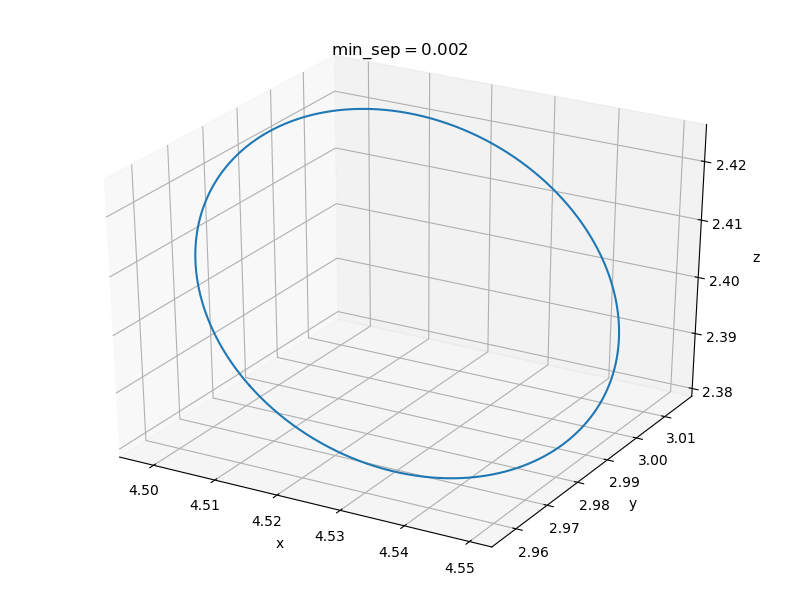

In [190]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

#j = -6

s = np.linspace(0,1,1000)

for l in mfs[-1].levelsets[:]:
    pts = np.array([l.interpolation(s0) for s0 in s])
    ax.plot(pts[:,0], pts[:,1], pts[:,2])
    
ax.set_title('min_sep$={}$'.format(min_seps[j]))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(0,2*np.pi)
#ax.set_ylim(0,2*np.pi)
#ax.set_zlim(0,2*np.pi)

plt.tight_layout()

In [79]:
max_dist_ang

1.2

In [135]:
np.sum([l.dist for l in mfs[-1].levelsets])

1.52

In [194]:
"""
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

s = np.linspace(0,1,1000)

for l in mf_ref_params.levelsets[:]:
    pts = np.array([l.interpolation(s0) for s0 in s])
    ax.plot(pts[:,0], pts[:,1], pts[:,2])
    
ax.set_title('Referanse, tol$=10^{-4}$')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(0,2*np.pi)
#ax.set_ylim(0,2*np.pi)
#ax.set_zlim(0,2*np.pi)

plt.tight_layout()
"""

"fig = plt.figure(figsize=(8,6))\nax = fig.add_subplot(111,projection='3d')\n\ns = np.linspace(0,1,1000)\n\nfor l in mf_ref_params.levelsets[:]:\n    pts = np.array([l.interpolation(s0) for s0 in s])\n    ax.plot(pts[:,0], pts[:,1], pts[:,2])\n    \nax.set_title('Referanse, tol$=10^{-4}$')\n\nax.set_xlabel('x')\nax.set_ylabel('y')\nax.set_zlabel('z')\n#ax.set_xlim(0,2*np.pi)\n#ax.set_ylim(0,2*np.pi)\n#ax.set_zlim(0,2*np.pi)\n\nplt.tight_layout()"

In [37]:
#t = time.time()
#mf_ref_params.add_level_sets(20,dist)
#print(time.time()-t)

Number of points in first geodesic level: 6
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 2 completed -> Points: 6 ,Time: 0.7655987739562988 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 3 completed -> Points: 6 ,Time: 1.7520604133605957 seconds
Geodesic level set 4 completed -> Points: 6 ,Time: 0.06566119194030762 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 5 completed -> Points: 10 ,Time: 0.5753219127655029 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 6 completed -> Points: 12 ,Time: 0.19826602935791016 seconds
Geodesic level set 7 completed -> Points: 13 ,Time: 0.28440380096435547 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 8 completed -> Points: 16 ,Time: 0.25336432456970215 seconds
Ge

In [ ]:
#[p.pos for p in mfs[0].levelsets[1].points]

In [87]:
#[p.pos for p in mfs[1].levelsets[1].points]

[array([4.47380423, 2.82634551, 2.36367438]),
 array([4.60885116, 2.89885601, 2.27660097]),
 array([4.66511798, 3.05097179, 2.32679513]),
 array([4.58185458, 3.14043026, 2.45052324]),
 array([4.4366552 , 3.07740553, 2.52574122]),
 array([4.38728021, 2.92096412, 2.48782496])]

In [377]:
np.sum(msk_abd_nm_fx)/(nx*ny*nz)

0.17907353271020993

In [380]:
np.where(msk_abd_nm_fx[...,48,39])

(array([18, 19, 20, 21, 22, 40, 41, 42, 87]),)